In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
os.listdir('data')

['Env_QH.csv',
 'micro_sud3.pkl',
 'AllPM_QH.csv',
 'micro_sud3_normalized.pkl',
 'AllNO2_QH.csv']

In [3]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    i = look_back
    while True:
        sequence = df.iloc[i - look_back:i]
        yield np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8) , np.array(sequence['NO2_ref'])
        i += 1
        if i == len(df):
            i = look_back
            
def dataframe_to_xy_test(df, look_back):
    X_test, y_test = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X_test.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y_test.append(np.array(sequence['NO2_ref']))
        i += 1
        if i == len(df):
            break
            
    return np.array(X_test), np.array(y_test)
            
        
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train = dataframe_to_xy(df_train, 10)
X_valid = dataframe_to_xy(df_valid, 10)
X_test, y_test = dataframe_to_xy_test(df_test, 10)

In [4]:
a = next(X_train)

In [5]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, activation='relu'))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim, activation='relu'))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=(input_dim),  activation='relu'))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


In [6]:
model = simple_rnn_model(16, (1, 8))
history = model.fit_generator(X_train, epochs=100, steps_per_epoch=16, validation_data=X_valid, validation_steps=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 16)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s - loss: 502.0076 - val_loss: 780.8221
Epoch 2/100
16/16 [==============================] - 0s - loss: 453.1312 - val_loss: 388.9150
Epoch 3/100
16/16 [==============================] - 0s - loss: 2007.1557 - val_loss: 284.4586
Epoch 4/100
16/16 [==============================] - 0s - loss: 5235.6291 - val_loss: 537.6940
Epoch 5/100
16/16 [==============================] - 0s - loss: 518.5087 - val_loss: 1060.5540
Epoch 6/100
16/16 [==============================] - 0s - loss: 439

16/16 [==============================] - 0s - loss: 390.7901 - val_loss: 164.2875
Epoch 81/100
16/16 [==============================] - 0s - loss: 395.2010 - val_loss: 152.7548
Epoch 82/100
16/16 [==============================] - 0s - loss: 41.3318 - val_loss: 102.6297
Epoch 83/100
16/16 [==============================] - 0s - loss: 131.4962 - val_loss: 169.4205
Epoch 84/100
16/16 [==============================] - 0s - loss: 205.8709 - val_loss: 51.3107
Epoch 85/100
16/16 [==============================] - 0s - loss: 156.4650 - val_loss: 139.4227
Epoch 86/100
16/16 [==============================] - 0s - loss: 114.4485 - val_loss: 197.7237
Epoch 87/100
16/16 [==============================] - 0s - loss: 38.1764 - val_loss: 250.1648
Epoch 88/100
16/16 [==============================] - 0s - loss: 114.3196 - val_loss: 392.5337
Epoch 89/100
16/16 [==============================] - 0s - loss: 88.4536 - val_loss: 1358.4285
Epoch 90/100
16/16 [==============================] - 0s - loss: 4

In [7]:
def dataframe_to_xy_no_generator(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [8]:
X_train, y_train = dataframe_to_xy_no_generator(df_train, 24)
X_valid, y_valid = dataframe_to_xy_no_generator(df_valid, 24)
X_test, y_test = dataframe_to_xy_no_generator(df_test, 24)

In [9]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=(input_dim)))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

In [10]:
model = simple_rnn_model(16, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 16)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1102 samples, validate on 539 samples
Epoch 1/5000
1102/1102 [==============================] - 1s - loss: 3390.6578 - val_loss: 3087.6329
Epoch 2/5000
1102/1102 [==============================] - 1s - loss: 3280.7122 - val_loss: 2983.1335
Epoch 3/5000
1102/1102 [==============================] - 1s - loss: 3150.0185 - val_loss: 2878.4458
Epoch 4/5000
1102/1102 [==============================] - 1s - loss: 3032.2643 - val_loss: 2780.2030
Epoch 5/5000
1102/1102 [==============================] - 1s - loss: 2928.7553 - val_loss: 2712.1791
Epoch 6/5000
1102/1102 [==============================] - 1s - loss: 2834.5679 - val_loss: 2630.4883
Epoch 7/5000
1102/1102 [==============================] - 1s - loss: 2754.9973 - val_loss: 2579.4693
Epoch 8/5000
1102/1102 [==============================] - 1s - loss: 2670.9846 - val_loss: 2525.0521
Epoch 9/5000
1102/1102 [==============================] - 1s - loss: 2612.4655 - val_loss: 2519.2546
Epoch 10/5000
1102/1102 [===================

1102/1102 [==============================] - 1s - loss: 415.3128 - val_loss: 472.3129
Epoch 82/5000
1102/1102 [==============================] - 1s - loss: 405.7417 - val_loss: 469.0575
Epoch 83/5000
1102/1102 [==============================] - 1s - loss: 398.7360 - val_loss: 461.4812
Epoch 84/5000
1102/1102 [==============================] - 1s - loss: 391.4817 - val_loss: 455.3405
Epoch 85/5000
1102/1102 [==============================] - 1s - loss: 381.8884 - val_loss: 452.5201
Epoch 86/5000
1102/1102 [==============================] - 1s - loss: 375.0334 - val_loss: 443.4019
Epoch 87/5000
1102/1102 [==============================] - 1s - loss: 367.9389 - val_loss: 441.2041
Epoch 88/5000
1102/1102 [==============================] - 1s - loss: 361.3558 - val_loss: 439.8161
Epoch 89/5000
1102/1102 [==============================] - 1s - loss: 354.6453 - val_loss: 433.6721
Epoch 90/5000
1102/1102 [==============================] - 1s - loss: 347.7679 - val_loss: 432.2054
Epoch 91/5000


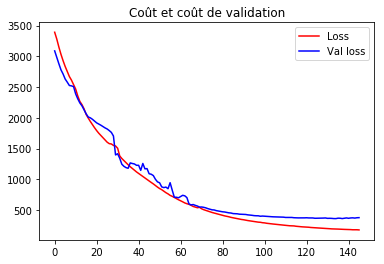

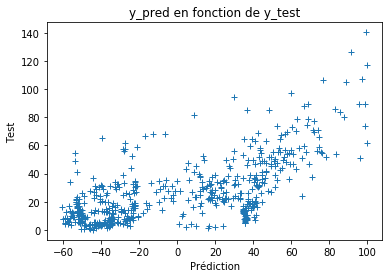

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
model = lstm_model(16, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1102 samples, validate on 539 samples
Epoch 1/5000
1102/1102 [==============================] - 7s - loss: 3404.7959 - val_loss: 3097.1270
Epoch 2/5000
1102/1102 [==============================] - 6s - loss: 3291.1023 - val_loss: 2895.7438
Epoch 3/5000
1102/1102 [==============================] - 6s - loss: 3077.1870 - val_loss: 2724.3822
Epoch 4/5000
1102/1102 [==============================] - 6s - loss: 2936.7535 - val_loss: 2605.7744
Epoch 5/5000
1102/1102 [==============================] - 6s - loss: 2821.9321 - val_loss: 2502.3994
Epoch 6/5000
1102/1102 [==============================] - 6s - loss: 2719.2868 - val_loss: 2407.6262
Epoch 7/5000
1102/1102 [==============================] - 6s - loss: 2624.5956 - val_loss: 2320.1426
Epoch 8/5000
1102/1102 [==============================] - 5s - loss: 2536.2638 - val_loss: 2238.1731
Epoch 9/5000
1102/1102 [==============================] - 5s - loss: 2453.2379 - val_loss: 2161.2478
Epoch 10/5000
1102/1102 [===================

1102/1102 [==============================] - 6s - loss: 385.6877 - val_loss: 495.5990
Epoch 82/5000
1102/1102 [==============================] - 6s - loss: 375.6373 - val_loss: 483.6108
Epoch 83/5000
1102/1102 [==============================] - 6s - loss: 369.7797 - val_loss: 483.6799
Epoch 84/5000
1102/1102 [==============================] - 6s - loss: 359.9891 - val_loss: 489.7028
Epoch 85/5000
1102/1102 [==============================] - 6s - loss: 352.2386 - val_loss: 502.5367
Epoch 86/5000
1102/1102 [==============================] - 6s - loss: 344.6619 - val_loss: 487.8846
Epoch 87/5000
1102/1102 [==============================] - 5s - loss: 339.5040 - val_loss: 498.8103
Epoch 88/5000
1102/1102 [==============================] - 6s - loss: 332.4453 - val_loss: 491.5153
Epoch 89/5000
1102/1102 [==============================] - 6s - loss: 325.6647 - val_loss: 497.1641
Epoch 90/5000
1102/1102 [==============================] - 6s - loss: 319.0963 - val_loss: 526.8046
Epoch 91/5000


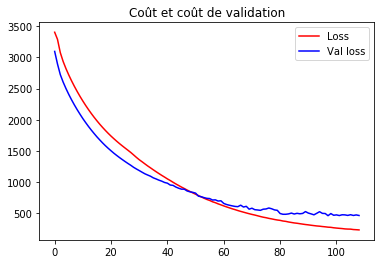

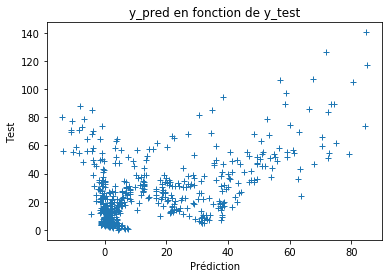

In [15]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [ ]:
model = gru_model(16, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                1200      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1102 samples, validate on 539 samples
Epoch 1/5000
1102/1102 [==============================] - 5s - loss: 3395.8139 - val_loss: 3082.0103
Epoch 2/5000
1102/1102 [==============================] - 5s - loss: 3264.8195 - val_loss: 2870.6495
Epoch 3/5000
1102/1102 [==============================] - 4s - loss: 3071.9799 - val_loss: 2727.1439
Epoch 4/5000
1102/1102 [==============================] - 5s - loss: 2942.7154 - val_loss: 2611.6766
Epoch 5/5000
1102/1102 [==============================] - 4s - loss: 2831.4128 - val_loss: 2512.1285
Epoch 6/5000
1102/1102 [==============================] - 4s - loss: 2730.8832 - val_loss: 2418.6966
Epoch 7/5000
1102/1102 [==============================] - 4s - loss: 2637.2298 - val_loss: 2331.7345
Epoch 8/5000
1102/1102 [==============================] - 4s - loss: 2549.5886 - val_loss: 2250.5542
Epoch 9/5000
1102/1102 [==============================] - 4s - loss: 2467.2935 - val_loss: 2172.7611
Epoch 10/5000
1102/1102 [===================

In [ ]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()